# 참조한 자료
[link](https://github.com/ligz08/Kaggle-Recruit-Restaurant-Visitor-Forecasting)   
참조한 이유는 해당인의 깃헙이 목차별로 잘 나눠져 있었으며, 가독성과 서술 부분에서 가장 만족스러웠다.

# 목차
- EDA
    - 날짜별 방문자 수 확인
    - 요일별 방문자 수 확인
- Feature Engineering & preprocessing¶
    - F1) 날짜별 공휴일
    - F2) 같은 지역별 store 갯수
    - F3) 남은 예약방문 일수와 시간
    - F4) 날짜별 요일 공휴일. 해당 날짜 방문자수 통계
    - F5) 머신러닝 학습을 위한 인코딩
- model 학습과 예측
    - xgboost를 이용하여 학습 후 예측
- xgboost tunning
    - 성능 개선을 위한 xgboost 튜닝

In [1]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

from subprocess import check_output
import seaborn as sns

import matplotlib.pyplot as plt

# EDA
EDA를 통해서
- task1) 날짜별 방문자 수를 보고 싶다.
- task2)요일별 방문자 수를 보고 싶다.

<EDA 상에서 사용하는 테이블>
- air_store : air상의 store 정보
- hpg_store : hpg상의 store 정보

- air_reserve : air상의 예약 정보
- hpg_reserve : hpg상의 예약 정보

- air_visits : air상의 방문자 수

- reserves : 총 예약에 대한 테이블 (air, hpg)
- stores : 총 store에 대한 테이블 (air, hpg)
- full : target(label) 와 방문자수 테이블을 합쳐놓은 것

등등

## store 확인

In [2]:
air_store = pd.read_csv('./data/air_store_info.csv')
hpg_store = pd.read_csv('./data/hpg_store_info.csv')

In [3]:
print(air_store.shape)
air_store.head(3)

(829, 5)


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853


In [4]:
print(hpg_store.shape)
hpg_store.head(3)

(4690, 5)


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


air 상의 전체 가게의 수는 829개이며,   
hpg 상의 전체 가게의 수는 4690개입니다.

## 예약과 방문 확인
- 예약
    - air_reserve : air_reserve.csv
    - hpg_reserve : hpg_reserve.csv
- 방문
    - air_visits : air_visits_data.csv

### air_reserve.csv 불러오기

In [5]:
air_reserve = pd.read_csv('./data/air_reserve.csv')
print("[null값] ", "\n", air_reserve.isnull().sum())

[null값]  
 air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64


In [6]:
print("전체 {}개의 가게 중 총 {}개의 예약이 있었습니다.".format(air_reserve.air_store_id.nunique(), len(air_reserve)))
print("air_reserve.shape : ", air_reserve.shape)
air_reserve.head(3)

전체 314개의 가게 중 총 92378개의 예약이 있었습니다.
air_reserve.shape :  (92378, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6


### air_visits_data.csv 불러오기 -> air_visits

In [7]:
air_visits = pd.read_csv('./data/air_visit_data.csv')
print("[null값] ", "\n", air_visits.isnull().sum())

[null값]  
 air_store_id    0
visit_date      0
visitors        0
dtype: int64


In [8]:
print("전체 {}개의 가게 중 총 {}개의 예약이 있었습니다.".format(air_visits.air_store_id.nunique(), len(air_visits)))
print("air_visits.shape : ", air_visits.shape)
air_visits.head(3)

전체 829개의 가게 중 총 252108개의 예약이 있었습니다.
air_visits.shape :  (252108, 3)


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29


In [9]:
# air_visit에 있던 모든 가게들이 air_store에도 있었습니까? -> true
print(air_visits.air_store_id.isin(air_store.air_store_id).all())

# air_store에 있던 모든 가게들이 air_visit에도 있었습니까> -> true
print(air_store.air_store_id.isin(air_visits.air_store_id).all())

# 하나의 가게도 빠짐없이 들어가 있습니다.

True
True


### hpg_reserve.csv 불러오기

In [10]:
hpg_reserve = pd.read_csv('./data/hpg_reserve.csv')

print("[null값]", "\n", hpg_reserve.isnull().sum())

print("\n")

print("hpg_reserve 테이블에서 hpg_store_id의 갯수: ", hpg_reserve.hpg_store_id.nunique())

[null값] 
 hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64


hpg_reserve 테이블에서 hpg_store_id의 갯수:  13325


In [11]:
print("전체 {}개의 가게 중 총 {}개의 예약이 있었습니다.".format(hpg_reserve.hpg_store_id.nunique(), len(hpg_reserve)))
print("hpg_reserve.shape : ", hpg_reserve.shape)
hpg_reserve.head(3)

전체 13325개의 가게 중 총 2000320개의 예약이 있었습니다.
hpg_reserve.shape :  (2000320, 4)


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2


- air_reserve 에서 92378개의 예약 
- air_visit 에서 252108개의 방문
- hpg_reserve 에서 2000320개의 예약

## 보조 자료
- date_info 의 칼럼에는 `calendar_date` | `day_of_weekday` | `holiday_flg` 가 있다.
    - Monday:0 ~ Sunday:6
    - day of week : 요일을 보여준다.
    - holiday_flg : flg 가 1이면 공휴일, 0이면 비공휴일
- store_id_lookup 의 칼럼에는 `air_store_id` | `hpg_store_id`가 있다.
    - air_store_id : air system상에 등록된 store id
    - hpg_store_id : hpg system상에 등록된 store id

### data_info.csv 불러오기

In [12]:
# flag에 1이면 공휴일, 0이면 비공휴일
date_info = pd.read_csv('./data/date_info.csv')
print("date_info.shape : ", date_info.shape)
date_info.head()

date_info.shape :  (517, 3)


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### store_id_relation.csv 불러오기 -> store_id_lookup

In [13]:
store_id_lookup = pd.read_csv('./data/store_id_relation.csv')
print("store_id_lookup.shape : ", store_id_lookup.shape)
store_id_lookup.tail()

store_id_lookup.shape :  (150, 2)


,air_store_id,hpg_store_id
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19
149,air_465bddfed3353b23,hpg_23c5945dc1a72454


## Target
- sample_submission.csv : kaggle에 제출해야되는 형식을 보여주는 파일

In [14]:
stores_to_pred = pd.read_csv('./data/sample_submission.csv')
print("stores_to_pred.shape : ", stores_to_pred.shape)
stores_to_pred.tail()

stores_to_pred.shape :  (32019, 2)


,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,0
32015,air_fff68b929994bfbd_2017-05-28,0
32016,air_fff68b929994bfbd_2017-05-29,0
32017,air_fff68b929994bfbd_2017-05-30,0
32018,air_fff68b929994bfbd_2017-05-31,0


### split()으로 id를 air_store_id와 date로 나눠줍니다.

In [15]:
# stores_to_pred의 id를 split()를 사용하여 쪼개서 id_split 테이블을 만든다.
id_split = stores_to_pred['id'].str.split('_', expand=True)
# 칼럼 이름을 재정의 해준다.
id_split.columns = ['source', 'store_id', 'visit_date']

# 기존의 stores_to_pred와 id_split을 합쳐서 새로운 stores_to_pred을 만든다.
stores_to_pred = pd.concat([stores_to_pred, id_split], axis=1)
# source와 store_id 컬럼을 합쳐서 air_store_id라는 컬럼을 새로 만든다.
stores_to_pred['air_store_id'] = stores_to_pred['source'].str.cat(stores_to_pred['store_id'], sep='_')
# stores_to_pred 컬럼 들 중 필요한 컬럼만 뽑아서 기존의 stores_to_pred에 덮어씌운다.
stores_to_pred = stores_to_pred[['id', 'air_store_id', 'visit_date', 'visitors']]
# visit_date를 split()함수로 써서 string형으로 되어있다. datetime으로 형변환을 해준다.
stores_to_pred['visit_date'] = pd.to_datetime(stores_to_pred['visit_date'])

stores_to_pred.head()

,id,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27,0


In [17]:
print("store 갯수 :", stores_to_pred.air_store_id.nunique())

store 갯수 : 821


In [18]:
# air_visits에 stores_to_pred와 동일하게 id 칼럼을 추가해준다.
air_visits['id'] = air_visits['air_store_id'].str.cat(air_visits['visit_date'].astype(str), sep='_')
print("air_visits.shape : ", air_visits.shape)
air_visits.tail()

air_visits.shape :  (252108, 4)


,air_store_id,visit_date,visitors,id
252103,air_24e8414b9b07decb,2017-04-18,6,air_24e8414b9b07decb_2017-04-18
252104,air_24e8414b9b07decb,2017-04-19,6,air_24e8414b9b07decb_2017-04-19
252105,air_24e8414b9b07decb,2017-04-20,7,air_24e8414b9b07decb_2017-04-20
252106,air_24e8414b9b07decb,2017-04-21,8,air_24e8414b9b07decb_2017-04-21
252107,air_24e8414b9b07decb,2017-04-22,5,air_24e8414b9b07decb_2017-04-22


In [20]:
air_visits.head()

,air_store_id,visit_date,visitors,id
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18


### full : air_visits랑 store_to_pred를 합친 테이블
keys=['past', 'future'] : air_visits 을 past, stores_to_pred를 future로 본다.
해당하는 칼럼의 이름은 dataset이며, dataset기준으로 index를 reset해준다.

In [19]:
full = pd.concat([air_visits, stores_to_pred], 
                 axis=0, keys=['past','future'], names=['dataset'])\
        .reset_index(level='dataset')\
        .reset_index(drop=True)

display(full.info())
display(full.head())
display(full.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284127 entries, 0 to 284126
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   dataset       284127 non-null  object
 1   air_store_id  284127 non-null  object
 2   visit_date    284127 non-null  object
 3   visitors      284127 non-null  int64 
 4   id            284127 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.8+ MB


None

,dataset,air_store_id,visit_date,visitors,id
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18


,dataset,air_store_id,visit_date,visitors,id
284122,future,air_fff68b929994bfbd,2017-05-27 00:00:00,0,air_fff68b929994bfbd_2017-05-27
284123,future,air_fff68b929994bfbd,2017-05-28 00:00:00,0,air_fff68b929994bfbd_2017-05-28
284124,future,air_fff68b929994bfbd,2017-05-29 00:00:00,0,air_fff68b929994bfbd_2017-05-29
284125,future,air_fff68b929994bfbd,2017-05-30 00:00:00,0,air_fff68b929994bfbd_2017-05-30
284126,future,air_fff68b929994bfbd,2017-05-31 00:00:00,0,air_fff68b929994bfbd_2017-05-31


In [21]:
full.to_csv('./data/full.csv', index=False)

In [22]:
# stores_to_pred의 air_store_id와 air_store의 air_store_id가 모두 일치하는지 확인한다.
stores_to_pred.air_store_id.isin(air_store.air_store_id).all()

True

### stores : air_store와 store_id_lookup을 합친 테이블. 
left join. key값으로 air_store_id를 사용했다.
- air_store : store 정보
- store_id_lookup : air_store_id와 hpg_store_id가 일치하는 것을 보여준다.

In [23]:
stores = pd.merge(air_store, store_id_lookup, how='left', on='air_store_id')
print("stores.shape : ", stores.shape)
stores.head()

stores.shape :  (829, 6)


,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN


In [24]:
print("stores 테이블에 hpg_store_id가 null의 비율 : ", stores['hpg_store_id'].isnull().mean())

stores 테이블에 hpg_store_id가 null의 비율 :  0.8190591073582629


### 기존의 stores 과 hpg_store(hpg system상에 store정보)를 합쳐서 새로운 stores 테이블을 만들어준다.
left join. key : `hpg_store_id`

In [25]:
# suffixes: stores상의 column들은 `_air`를 붙이고, hpg_store상의 column들은 `_hpg`를 접미사를 붙인다.
stores = pd.merge(stores, hpg_store, how='left', on='hpg_store_id', suffixes=['_air', '_hpg'])
print("stores.shape : ", stores.shape)
stores.head()

stores.shape :  (829, 10)


,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [26]:
print("stores 테이블에 hpg_genre_name 칼럼 중 null값의 비율", stores.hpg_genre_name.isnull().mean())

stores 테이블에 hpg_genre_name 칼럼 중 null값의 비율 0.9240048250904704


In [27]:
stores.to_csv('./data/stores.csv', index=False)

### hpg_reserve 
- 기존의 hpg_reserve와 store_id_lookup 테이블을 합친다. 
- key는 hpg_store_id.    
- 합친 테이블에서 air_reserve에 해당하는 칼럼들만 뽑아서 hpg_reserve로 새로 생성한다.

In [29]:
print(air_reserve.columns)
air_reserve.head()

Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors'],
      dtype='object')


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [30]:
hpg_reserve = pd.merge(hpg_reserve, store_id_lookup, on='hpg_store_id')[air_reserve.columns]

print("hpg_reserve.shape : ", hpg_reserve.shape)
hpg_reserve.head()

hpg_reserve.shape :  (28183, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
1,air_db80363d35f10926,2016-01-02 19:00:00,2016-01-02 14:00:00,2
2,air_db80363d35f10926,2016-01-03 18:00:00,2016-01-02 20:00:00,6
3,air_db80363d35f10926,2016-01-06 20:00:00,2016-01-04 22:00:00,3
4,air_db80363d35f10926,2016-01-11 18:00:00,2016-01-11 14:00:00,2


### reserves
air_reserve와 hpg_reserve 테이블을 합친다.

In [31]:
reserves = pd.concat([air_reserve, hpg_reserve], axis=0)

print("reserves.shape : ", reserves.shape)
reserves.head()

reserves.shape :  (120561, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [32]:
reserves.to_csv("./data/reserves.csv", index=False)

In [33]:
# air_visits 상에 visit_date를 str(아까 위에서 str.split()을 해줘서 string type으로 되어 있다.) -> datatime으로 형변환 해준다.
air_visits.visit_date = pd.to_datetime(air_visits.visit_date)
air_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   air_store_id  252108 non-null  object        
 1   visit_date    252108 non-null  datetime64[ns]
 2   visitors      252108 non-null  int64         
 3   id            252108 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 7.7+ MB


In [34]:
# air_visits에서 visit_date별 방문자수 합계
visitors_by_date = air_visits.groupby('visit_date').sum()
visitors_by_date.head()

,visitors
visit_date,
2016-01-01,1033
2016-01-02,1764
2016-01-03,2368
2016-01-04,3326
2016-01-05,3927


### task1)

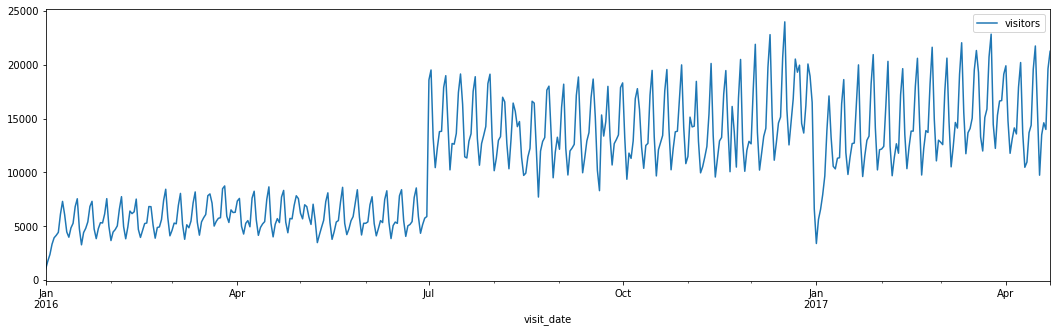

In [35]:
## visit_date별 방문자수 시각화
ax = visitors_by_date.plot(figsize=[18,5])

In [41]:
# visitors_by_date.reset_index(inplace=True)
display(visitors_by_date[visitors_by_date["visit_date"] > "2016-12-25"].head(20))
display(visitors_by_date[visitors_by_date["visit_date"] > "2016-06-20"].head(20))

,level_0,index,visit_date,visitors
360,360,360,2016-12-26,13656
361,361,361,2016-12-27,16182
362,362,362,2016-12-28,20069
363,363,363,2016-12-29,18941
364,364,364,2016-12-30,16499
365,365,365,2016-12-31,6616
366,366,366,2017-01-01,3396
367,367,367,2017-01-02,5631
368,368,368,2017-01-03,6574
369,369,369,2017-01-04,7922


,level_0,index,visit_date,visitors
172,172,172,2016-06-21,5039
173,173,173,2016-06-22,5160
174,174,174,2016-06-23,5429
175,175,175,2016-06-24,7667
176,176,176,2016-06-25,8555
177,177,177,2016-06-26,5896
178,178,178,2016-06-27,4346
179,179,179,2016-06-28,5146
180,180,180,2016-06-29,5748
181,181,181,2016-06-30,5898


2016년 7월에 급격하게 방문자수가 늘어났으며, 2017년 1월에 방문자수에 타격이 있는것으로 보인다.   
2016년 7월에는 왜 저렇게 대폭 늘었는지 모르겠습니다. [연합뉴스](https://www.yna.co.kr/view/AKR20160701073100004) 측에선 일본 노선 하늘길이 늘었다고 기사가 있지만, 어떤 변수로 인해 저런 식으로 증가했는지는 아무도 모릅니다.   
2017년 1월에 무슨 일이 있었는지, 뉴스가 나오지 않습니다... 예상하기 로는 일본 신년 때문에 다들 문닫고 놀러가는 거 같습니다....

In [42]:
# 기존의 air_visits
display(air_visits.head())

# air_visits의 visit_date에서 요일을 도출해 weekday 컬럼을 추가해준다.
# Monday : 0 ~ Sunday : 6
air_visits['weekday'] = air_visits.visit_date.dt.weekday

print("air_visits.shape : ", air_visits.shape)
display(air_visits.head())

,air_store_id,visit_date,visitors,id
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18


air_visits.shape :  (252108, 5)


,air_store_id,visit_date,visitors,id,weekday
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0


In [43]:
# weekday별 방문자수의 합계를 visitors_by_weekday라는 테이블로 만들어준다.
# Monday : 0 ~ Sunday : 6
visitors_by_weekday = air_visits.groupby('weekday')['visitors'].sum()

print("visitors_by_weekday.shape : ", visitors_by_weekday.shape)
visitors_by_weekday

visitors_by_weekday.shape :  (7,)


weekday
0     544202
1     636462
2     707880
3     718987
4     931008
5    1033128
6     715986
Name: visitors, dtype: int64

### task2)

Text(0.5, 0, 'Weekday (Monday=0, Sunday=6)')

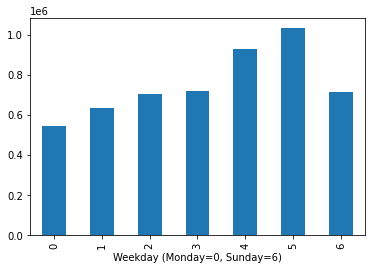

In [44]:
## 요일별 방문자수 시각화
ax = visitors_by_weekday.plot.bar()
ax.set_xlabel('Weekday (Monday=0, Sunday=6)')

토요일(5)에 방문자가 가장 많은 것을 확인할 수 있다.

-----------
# Feature Engineering & preprocessing

- F1) 1월 1일을 기준으로 1월 1일, 2일, 3일, 4일, 5일처럼 각 날짜의 방문 날짜와의 차이를 확인한다. 그 후 각 날짜별로 어제와 내일이 공휴일인지 알려주는 칼럼을 생성한다.
- F2) 같은 지역, 같은 도시에 몇개의 store가 몇개가 있을까?
- F3) 예약한 날짜(reserve_datetime)로 부터 예약방문(visit_datetime)하기로 한 날짜와의 일수(day)와 시간(hour)은 얼마나 남았을까?
- F4) 각 날짜별 요일이 공휴일인지, 아닌지 확인해보고 싶다. 그리고 해당일에 방문자수의 통계(mean, median, min, max 등등)를 알고싶다.
- F5) 기본적으로 머신러닝 알고리즘은 문자열 값을 입력값으로 사용할 수 없다. 따라서 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업을 마친 후에 머신러닝 모델에 학습을 시킨다.

### full 불러오기

In [46]:
full = pd.read_csv('./data/full.csv', parse_dates=['visit_date']) # parse_dates : datetime형으로 지정해줄 칼럼을 정해준다.
display(full.info())
display(full.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284127 entries, 0 to 284126
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   dataset       284127 non-null  object        
 1   air_store_id  284127 non-null  object        
 2   visit_date    284127 non-null  datetime64[ns]
 3   visitors      284127 non-null  int64         
 4   id            284127 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 10.8+ MB


None

,dataset,air_store_id,visit_date,visitors,id
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18


In [47]:
## visit_date에서 각 날짜를 weekday, year, month 등등의 컬럼으로 만들기

full['weekday'] = full.visit_date.dt.dayofweek
full['year'] = full.visit_date.dt.year
full['month'] = full.visit_date.dt.month
full['day_of_year'] = full.visit_date.dt.dayofyear
full['days_in_month'] = full.visit_date.dt.days_in_month
full['week_of_year'] = full.visit_date.dt.weekofyear
full['is_month_end'] = full.visit_date.dt.is_month_end

print("full.shape : ", full.shape)
full.head()

full.shape :  (284127, 12)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,week_of_year,is_month_end
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,2,False
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,2,False
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,2,False
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,2,False
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,3,False


In [48]:
# air_visits의 테이블에 2016년 1월 13일 부터 시작합니다. 1월 1일 데이터가 없다고 생각하지마세요. 있습니다.
# 귀찮아서 안 보여 드릴겁니다.

# full[full.visit_date == "2016-01-01"]
full.visit_date.min()

Timestamp('2016-01-01 00:00:00')

### F1) 1월 1일을 기준으로 1월 1일, 2일, 3일, 4일, 5일처럼 각 날짜의 방문 날짜와의 차이를 확인한다. 그 후 각 날짜별로 어제와 내일이 공휴일인지 알려주는 칼럼을 생성한다.

In [49]:
first_day = pd.to_datetime('2016-01-01')
first_day

Timestamp('2016-01-01 00:00:00')

In [50]:
# 2016년 1월 1일부터 방문날짜까지의 차이를 days_since_20160101칼럼으로 생성한다.
full['days_since_20160101'] = (full.visit_date - first_day).apply(lambda dt: dt.days)
full.head()

,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,week_of_year,is_month_end,days_since_20160101
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,2,False,12
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,2,False,13
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,2,False,14
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,2,False,15
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,3,False,17


### 공휴일인지 알아보기 : holiday_info

In [51]:
holiday_info = pd.read_csv('./data/date_info.csv',  
                           parse_dates=['calendar_date'])

print("holiday_info.shape : ", holiday_info.shape)
holiday_info.head()

holiday_info.shape :  (517, 3)


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [52]:
# 어제와 내일이 공휴일인지(공휴일: 1, 비공휴일: 0)를 칼럼으로 생성해준다.
holiday_info['tomorrow_is_holiday'] = holiday_info.holiday_flg.shift(-1).fillna(0).astype(int)
holiday_info['yesterday_is_holiday'] = holiday_info.holiday_flg.shift(1).fillna(0).astype(int)

print("holiday_info.shape : ", holiday_info.shape)
holiday_info.head()

holiday_info.shape :  (517, 5)


,calendar_date,day_of_week,holiday_flg,tomorrow_is_holiday,yesterday_is_holiday
0,2016-01-01,Friday,1,1,0
1,2016-01-02,Saturday,1,1,1
2,2016-01-03,Sunday,1,0,1
3,2016-01-04,Monday,0,0,1
4,2016-01-05,Tuesday,0,0,0


### 기존의 full 테이블이랑 holiday_info 테이블을 합치는 작업으로 새로운 full 테이블 생성한다.

In [53]:
full = pd.merge(left=full, 
                right=holiday_info.drop('day_of_week', axis=1), 
                how='left', 
                left_on='visit_date', right_on='calendar_date')\
        .drop('calendar_date', axis=1)

print("full.shape : ", full.shape)
full.head()

full.shape :  (284127, 16)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,week_of_year,is_month_end,days_since_20160101,holiday_flg,tomorrow_is_holiday,yesterday_is_holiday
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,2,False,12,0,0,0
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,2,False,13,0,0,0
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,2,False,14,0,0,0
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,2,False,15,0,0,0
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,3,False,17,0,0,0


### stores.csv :  stores들의 위치를 불러오기

In [54]:
stores = pd.read_csv('./data/stores.csv')

print("stores.shape : ", stores.shape)
stores.head()

stores.shape :  (829, 10)


,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


### F2) 같은 지역, 같은 도시에 몇개의 store가 몇개가 있을까?

In [55]:
# stores의 air_area_name을  Todofuken, city, street 으로 나눠 칼럼들을 추가해줬습니다.
area_split = stores.air_area_name.str.split(' ', expand=True)

stores['Todofuken'] = area_split[0]
stores['city'] = area_split[1]
stores['street'] = area_split.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)

print("stores.shape : ", stores.shape)
stores.head()

stores.shape :  (829, 13)


,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg,Todofuken,city,street
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen


In [56]:
# stores 테이블 상에 같은 지역에 있는 가게들의 갯수를 센다.
n_stores_by_street = stores.groupby(['air_area_name']).size().to_frame(name='n_stores_same_street').reset_index()
n_stores_by_city = stores.groupby(['Todofuken', 'city']).size().to_frame(name='n_stores_same_city').reset_index()
n_stores_by_Todofuken = stores.groupby('Todofuken').size().to_frame(name='n_stores_same_Todofuken').reset_index()

In [57]:
# street에 대한 테이블
print("n_stores_by_street.shape", n_stores_by_street.shape)
n_stores_by_street.head()

n_stores_by_street.shape (103, 2)


,air_area_name,n_stores_same_street
0,Fukuoka-ken Fukuoka-shi Daimyō,64
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,16
2,Fukuoka-ken Fukuoka-shi Imaizumi,2
3,Fukuoka-ken Fukuoka-shi Momochi,6
4,Fukuoka-ken Fukuoka-shi Shiobaru,7


In [58]:
## city에 대한 테이블
print("n_stores_by_city.shape", n_stores_by_city.shape)
n_stores_by_city.head()

n_stores_by_city.shape (55, 3)


,Todofuken,city,n_stores_same_city
0,Fukuoka-ken,Fukuoka-shi,103
1,Fukuoka-ken,Itoshima-shi,7
2,Fukuoka-ken,Kitakyūshū-shi,9
3,Fukuoka-ken,Kurume-shi,6
4,Fukuoka-ken,Yame-shi,2


In [59]:
# Todofuken에 대한 테이블
print("n_stores_by_Todofuken.shape", n_stores_by_Todofuken.shape)
n_stores_by_Todofuken

n_stores_by_Todofuken.shape (9, 2)


,Todofuken,n_stores_same_Todofuken
0,Fukuoka-ken,127
1,Hiroshima-ken,32
2,Hokkaidō,46
3,Hyōgo-ken,57
4,Miyagi-ken,17
5,Niigata-ken,14
6,Shizuoka-ken,18
7,Tōkyō-to,444
8,Ōsaka-fu,74


### stores
기존의 stores 테이블과 street, city, Todofuken 테이블들을 합쳐서 새로운 stores 테이블을 생성.

In [60]:
stores = pd.merge(left=stores, right=n_stores_by_street, how='left', on='air_area_name')
stores = pd.merge(left=stores, right=n_stores_by_city, how='left', on=['Todofuken', 'city'])
stores = pd.merge(left=stores, right=n_stores_by_Todofuken, how='left', on='Todofuken')

print("stores.shape : ", stores.shape)
stores.head()

stores.shape :  (829, 16)


,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg,Todofuken,city,street,n_stores_same_street,n_stores_same_city,n_stores_same_Todofuken
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri,17,25,57
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri,17,25,57
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri,17,25,57
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN,Hyōgo-ken,Kōbe-shi,Kumoidōri,17,25,57
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444


### full
full 테이블에 stores 테이블을 이어붙여준다.

In [61]:
full = pd.merge(left=full, right=stores, how='left', on='air_store_id')

print("full.shape : ", full.shape)
full.head()

full.shape :  (284127, 31)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg,Todofuken,city,street,n_stores_same_street,n_stores_same_city,n_stores_same_Todofuken
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,NaN,NaN,NaN,NaN,Tōkyō-to,Minato-ku,Shibakōen,51,61,444


### reserves.csv 불러오기

In [62]:
reserves = pd.read_csv('./data/reserves.csv', parse_dates=['visit_datetime', 'reserve_datetime'])

print("reserves.shape", reserves.shape)
display(reserves.info())
display(reserves.head())

reserves.shape (120561, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120561 entries, 0 to 120560
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      120561 non-null  object        
 1   visit_datetime    120561 non-null  datetime64[ns]
 2   reserve_datetime  120561 non-null  datetime64[ns]
 3   reserve_visitors  120561 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 3.7+ MB


None

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


### 

### F3) 예약한 날짜(reserve_datetime)로 부터 예약방문(visit_datetime)하기로 한 날짜와의 일수(day)와 시간(hour)은 얼마나 남았을까?

In [63]:
# reserves 에서 남은 예약 일수와 시간을 칼럼으로 생성해준다.
reserves['planned_visit_date'] = reserves.visit_datetime.dt.date.astype('datetime64[ns]')
reserves['reserve_date']  = reserves.reserve_datetime.dt.date
reserves['reserve_ahead'] = reserves.visit_datetime - reserves.reserve_datetime.astype('datetime64[ns]')
reserves['hours_ahead'] = reserves.reserve_ahead / pd.Timedelta('1 hour')
reserves['days_ahead'] = reserves.reserve_ahead.apply(lambda delta_t: delta_t.days)

print("reserves.shape : ", reserves.shape)
display(reserves.info())
display(reserves.head())

reserves.shape :  (120561, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120561 entries, 0 to 120560
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   air_store_id        120561 non-null  object         
 1   visit_datetime      120561 non-null  datetime64[ns] 
 2   reserve_datetime    120561 non-null  datetime64[ns] 
 3   reserve_visitors    120561 non-null  int64          
 4   planned_visit_date  120561 non-null  datetime64[ns] 
 5   reserve_date        120561 non-null  object         
 6   reserve_ahead       120561 non-null  timedelta64[ns]
 7   hours_ahead         120561 non-null  float64        
 8   days_ahead          120561 non-null  int64          
dtypes: datetime64[ns](3), float64(1), int64(2), object(2), timedelta64[ns](1)
memory usage: 8.3+ MB


None

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,planned_visit_date,reserve_date,reserve_ahead,hours_ahead,days_ahead
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,0 days 03:00:00,3.0,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,0 days 00:00:00,0.0,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,0 days 00:00:00,0.0,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,0 days 04:00:00,4.0,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,0 days 19:00:00,19.0,0


### reserve에 대한 요약

In [64]:
reserve_summary = reserves.groupby(['air_store_id', 'planned_visit_date'])['reserve_visitors', 'hours_ahead']\
                        .agg({'reserve_visitors': ['count','sum'], 'hours_ahead': 'mean'})\
                        .reset_index()
reserve_summary.columns=['air_store_id', 'planned_visit_date', 
                     'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead']

print("reserve_summary.shape : ",reserve_summary.shape)
reserve_summary.head()

reserve_summary.shape :  (42193, 5)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,air_store_id,planned_visit_date,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead
0,air_00a91d42b08b08d9,2016-01-14,1,2,77.0
1,air_00a91d42b08b08d9,2016-01-15,1,4,142.0
2,air_00a91d42b08b08d9,2016-01-16,1,2,70.0
3,air_00a91d42b08b08d9,2016-01-22,1,2,82.0
4,air_00a91d42b08b08d9,2016-01-29,1,5,144.0


### full 
기존 full 테이블과 reserve_summary 테이블을 합친다.

In [65]:
full = pd.merge(left=full, right=reserve_summary, how='left', 
                left_on=['air_store_id', 'visit_date'], 
                right_on=['air_store_id', 'planned_visit_date'])
print("full.shape : ", full.shape)
full.head()

full.shape :  (284127, 35)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,Todofuken,city,street,n_stores_same_street,n_stores_same_city,n_stores_same_Todofuken,planned_visit_date,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,Tōkyō-to,Minato-ku,Shibakōen,51,61,444,NaT,NaN,NaN,NaN
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,Tōkyō-to,Minato-ku,Shibakōen,51,61,444,NaT,NaN,NaN,NaN
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,Tōkyō-to,Minato-ku,Shibakōen,51,61,444,NaT,NaN,NaN,NaN
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,Tōkyō-to,Minato-ku,Shibakōen,51,61,444,NaT,NaN,NaN,NaN
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,Tōkyō-to,Minato-ku,Shibakōen,51,61,444,NaT,NaN,NaN,NaN


In [66]:
# n_reserves(예약수)가 null값의 비율
full.n_reserves.isnull().mean()

0.8698926888328107

### 

### F4) 각 날짜별 요일이 공휴일인지, 아닌지 확인해보고 싶다. 그리고 해당일에 방문자수의 통계(mean, median, min, max 등등)를 알고싶다.

In [67]:
# 데이터 타입이 string인 칼럼들을 이어붙여주는 함수.
def catStrFeatures(df, colname1, colname2, sep='_'):
    series = df[colname1].astype(str).str.cat(df[colname2].astype(str), sep=sep)
    return series

In [68]:
full['area_genre'] = catStrFeatures(full, 'air_area_name', 'air_genre_name')
full['store_weekday'] = catStrFeatures(full, 'air_store_id', 'weekday')
full['store_weekday_holiday'] = catStrFeatures(full, 'store_weekday', 'holiday_flg')

In [70]:
print("full.shape : ",full.shape)
full.head()

full.shape :  (284127, 38)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,n_stores_same_street,n_stores_same_city,n_stores_same_Todofuken,planned_visit_date,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead,area_genre,store_weekday,store_weekday_holiday
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,51,61,444,NaT,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_2,air_ba937bf13d40fb24_2_0
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,51,61,444,NaT,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_3,air_ba937bf13d40fb24_3_0
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,51,61,444,NaT,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_4,air_ba937bf13d40fb24_4_0
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,51,61,444,NaT,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_5,air_ba937bf13d40fb24_5_0
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,51,61,444,NaT,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_0,air_ba937bf13d40fb24_0_0


### 

In [71]:
# full테이블의 dataset이 past 데이터중에서 
# groupby기준으로 visitors(방문자)에 대한 평균(mean), 중간값(median), 최소(min), 최대(max)로 
# 이루어진 visitor_stats테이블을 생성한다.
group_by_cols = ['air_store_id', 'weekday', 'holiday_flg']

visitor_stats = full.query('dataset == "past"')\
                .groupby(group_by_cols)['visitors']\
                .agg(['mean', 'median', 'min', 'max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

print("visitor_stats.shape : ", visitor_stats.shape)
visitor_stats.head()

visitor_stats.shape :  (10461, 7)


,air_store_id,weekday,holiday_flg,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9,0,0,22.500000,19.0,1,47
1,air_00a91d42b08b08d9,0,1,21.000000,21.0,21,21
2,air_00a91d42b08b08d9,1,0,24.350000,24.5,1,43
3,air_00a91d42b08b08d9,2,0,28.125000,28.0,15,52
4,air_00a91d42b08b08d9,3,0,29.868421,30.0,15,47


### full : full 테이블에 visitor_stats 테이블을 합쳐준다.

In [72]:
full = full.merge(visitor_stats, how='left', on=group_by_cols)

print("full.shape : ",full.shape)
full.head()

full.shape :  (284127, 42)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead,area_genre,store_weekday,store_weekday_holiday,mean_visitors,median_visitors,min_visitors,max_visitors
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_2,air_ba937bf13d40fb24_2_0,24.095238,25.0,7.0,57.0
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_3,air_ba937bf13d40fb24_3_0,20.450000,21.0,7.0,45.0
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_4,air_ba937bf13d40fb24_4_0,35.218750,35.5,17.0,61.0
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_5,air_ba937bf13d40fb24_5_0,27.828125,27.0,6.0,53.0
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_0,air_ba937bf13d40fb24_0_0,13.754386,12.0,2.0,34.0


### reformat features

In [73]:
display(full.info())
display(full.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   dataset                  284127 non-null  object        
 1   air_store_id             284127 non-null  object        
 2   visit_date               284127 non-null  datetime64[ns]
 3   visitors                 284127 non-null  int64         
 4   id                       284127 non-null  object        
 5   weekday                  284127 non-null  int64         
 6   year                     284127 non-null  int64         
 7   month                    284127 non-null  int64         
 8   day_of_year              284127 non-null  int64         
 9   days_in_month            284127 non-null  int64         
 10  week_of_year             284127 non-null  int64         
 11  is_month_end             284127 non-null  bool          
 12  days_since_20160

None

,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead,area_genre,store_weekday,store_weekday_holiday,mean_visitors,median_visitors,min_visitors,max_visitors
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_2,air_ba937bf13d40fb24_2_0,24.095238,25.0,7.0,57.0
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_3,air_ba937bf13d40fb24_3_0,20.450000,21.0,7.0,45.0
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_4,air_ba937bf13d40fb24_4_0,35.218750,35.5,17.0,61.0
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_5,air_ba937bf13d40fb24_5_0,27.828125,27.0,6.0,53.0
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,NaN,NaN,NaN,Tōkyō-to Minato-ku Shibakōen_Dining bar,air_ba937bf13d40fb24_0,air_ba937bf13d40fb24_0_0,13.754386,12.0,2.0,34.0


In [74]:
full.columns

Index(['dataset', 'air_store_id', 'visit_date', 'visitors', 'id', 'weekday',
       'year', 'month', 'day_of_year', 'days_in_month', 'week_of_year',
       'is_month_end', 'days_since_20160101', 'holiday_flg',
       'tomorrow_is_holiday', 'yesterday_is_holiday', 'air_genre_name',
       'air_area_name', 'latitude_air', 'longitude_air', 'hpg_store_id',
       'hpg_genre_name', 'hpg_area_name', 'latitude_hpg', 'longitude_hpg',
       'Todofuken', 'city', 'street', 'n_stores_same_street',
       'n_stores_same_city', 'n_stores_same_Todofuken', 'planned_visit_date',
       'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead',
       'area_genre', 'store_weekday', 'store_weekday_holiday', 'mean_visitors',
       'median_visitors', 'min_visitors', 'max_visitors'],
      dtype='object')

In [75]:
# categorical columns : 범주형 컬럼
cat_cols = ['air_store_id', 'air_genre_name', 'air_area_name', 
            'hpg_genre_name', 'hpg_area_name',
            'Todofuken', 'city', 'street', 
            'area_genre', 'store_weekday', 'store_weekday_holiday'
           ]

# binary columns (T/F or 1/0) : binary 컬럼
bin_cols = ['is_month_end', 'holiday_flg', 'tomorrow_is_holiday', 'yesterday_is_holiday']

# numeric columns : 수치형 컬럼
num_cols = ['weekday', 'year', 'month', 'day_of_year', 'days_in_month', 'week_of_year', 'days_since_20160101', # date
            'latitude_air', 'longitude_air',   # location
            'n_stores_same_street', 'n_stores_same_city', 'n_stores_same_Todofuken',    # neighbor
            'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead',  # reserves
            'mean_visitors', 'median_visitors', 'min_visitors', 'max_visitors'    # simple aggregation of visitors
           ]    

# id columns
id_col = 'id'

# target column
target_col = 'visitors'

### F5) 기본적으로 머신러닝 알고리즘은 문자열 값을 입력값으로 사용할 수 없다.
### 따라서 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업을 마친 후에 머신러닝 모델에 학습을 시킨다.

### Cat features
- Categorical/string label → integers -> int encoding(Label encoding)
- Integer → columns of 0/1 -> ont-hot endcoding

#### Label encoding
Categorical/string label → integer

In [77]:
# sklearn.preprocessing에서 label encoding을 도와주는 LabelEncoder를 불러온다.
from sklearn.preprocessing import LabelEncoder

In [78]:
# cateogorical로 되어 있는 컬럼들의 이름에 `_int`라는 접미사를 붙인 컬럼 리스트(cat2int_cols)를 정의.
cat2int_cols = [ cat+'_int' for cat in cat_cols ]    

# cat2int_encoders: LabelEncoder를 할당한 dictionary 
cat2int_encoders = {}

In [79]:
%%time

for cat, cat2int in zip(cat_cols, cat2int_cols):
    encoder = LabelEncoder()
    full[cat2int] = encoder.fit_transform(full[cat].astype(str))
    cat2int_encoders[cat] = encoder

CPU times: user 694 ms, sys: 18.9 ms, total: 713 ms
Wall time: 712 ms


In [81]:
cat2int_encoders

{'air_store_id': LabelEncoder(),
 'air_genre_name': LabelEncoder(),
 'air_area_name': LabelEncoder(),
 'hpg_genre_name': LabelEncoder(),
 'hpg_area_name': LabelEncoder(),
 'Todofuken': LabelEncoder(),
 'city': LabelEncoder(),
 'street': LabelEncoder(),
 'area_genre': LabelEncoder(),
 'store_weekday': LabelEncoder(),
 'store_weekday_holiday': LabelEncoder()}

In [80]:
full[cat2int_cols].head()

,air_store_id_int,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
0,603,4,62,16,31,7,29,77,144,4222,7860
1,603,4,62,16,31,7,29,77,144,4223,7862
2,603,4,62,16,31,7,29,77,144,4224,7864
3,603,4,62,16,31,7,29,77,144,4225,7866
4,603,4,62,16,31,7,29,77,144,4220,7858


#### One-hot encoding
Integer label → columns of 0/1

In [82]:
# sklearn.preprocessing에서 one-hot encoding을 도와주는 OneHotEncoder를 불러온다.
from sklearn.preprocessing import OneHotEncoder

In [83]:
%%time
onehot_encoder = OneHotEncoder(sparse=True)
cat2onehot_sparse = onehot_encoder.fit_transform(full[cat2int_cols])

CPU times: user 209 ms, sys: 11.9 ms, total: 220 ms
Wall time: 219 ms


In [85]:
print("cat2onehot_sparse.shape : ", cat2onehot_sparse.shape)

cat2onehot_sparse.shape :  (284127, 18026)


In [92]:
for cat in cat_cols: 
    for level in cat2int_encoders[cat].classes_:
        print(cat, level)

air_store_id air_00a91d42b08b08d9
air_store_id air_0164b9927d20bcc3
air_store_id air_0241aa3964b7f861
air_store_id air_0328696196e46f18
air_store_id air_034a3d5b40d5b1b1
air_store_id air_036d4f1ee7285390
air_store_id air_0382c794b73b51ad
air_store_id air_03963426c9312048
air_store_id air_04341b588bde96cd
air_store_id air_049f6d5b402a31b2
air_store_id air_04cae7c1bc9b2a0b
air_store_id air_0585011fa179bcce
air_store_id air_05c325d315cc17f5
air_store_id air_0647f17b4dc041c8
air_store_id air_064e203265ee5753
air_store_id air_066f0221b8a4d533
air_store_id air_06f95ac5c33aca10
air_store_id air_0728814bd98f7367
air_store_id air_0768ab3910f7967f
air_store_id air_07b314d83059c4d2
air_store_id air_07bb665f9cdfbdfb
air_store_id air_082908692355165e
air_store_id air_083ddc520ea47e1e
air_store_id air_0845d8395f30c6bb
air_store_id air_084d98859256acf0
air_store_id air_0867f7bebad6a649
air_store_id air_08ba8cd01b3ba010
air_store_id air_08cb3c4ee6cd6a22
air_store_id air_08ef81d5b7a0d13f
air_store_id a

In [89]:
# cat_cols와 cat2int_encoders를 이어붙인다.
cat2onehot_cols = [ cat+'__is__'+str(level).replace(' ', '_') 
                   for cat in cat_cols for level in cat2int_encoders[cat].classes_]

In [90]:
import random
random.sample(cat2onehot_cols, 20)

['area_genre__is__Tōkyō-to_Meguro-ku_Takaban_Italian/French',
 'hpg_genre_name__is__International_cuisine',
 'store_weekday_holiday__is__air_831658500aa7c846_3_0',
 'store_weekday_holiday__is__air_a38f25e3399d1b25_4_1',
 'air_store_id__is__air_1e23210b584540e7',
 'store_weekday_holiday__is__air_747f375eb3900e1e_5_1',
 'store_weekday__is__air_af63df35857b16e6_3',
 'store_weekday__is__air_ecf7f141339f1d57_5',
 'air_store_id__is__air_75bd5d1b6dc6670d',
 'store_weekday__is__air_68301bcb11e2f389_0',
 'store_weekday_holiday__is__air_0382c794b73b51ad_4_1',
 'store_weekday__is__air_ad7777590c884721_4',
 'store_weekday_holiday__is__air_e5cf003abcc5febb_6_0',
 'store_weekday_holiday__is__air_349278fa964bb12f_3_1',
 'store_weekday_holiday__is__air_4de6d887a7b1c1fc_6_1',
 'store_weekday__is__air_3d3a2b509180e798_6',
 'store_weekday__is__air_f4936b91c9addbf0_0',
 'store_weekday_holiday__is__air_84060403939d8216_5_0',
 'store_weekday_holiday__is__air_2bffb19a24d11729_5_1',
 'store_weekday_holiday__i

## engineering한 데이터들을 pickle 패키지를 이용하여 객체로 저장한다.
- full_engineered.pkl : full 테이블이 저장되어있다.
- variables.pkl : encoding한 데이터들이 저장되어있다.

In [93]:
import os
import pickle
if not os.path.exists('data'): os.mkdir('data')

In [94]:
full.to_pickle('./data/full_engineered.pkl')

with open('./data/variables.pkl', 'wb') as f:
    pickle.dump([cat_cols, num_cols, bin_cols, id_col, target_col,
                 cat2int_cols, cat2int_encoders, cat2onehot_cols,
                 cat2onehot_sparse], f)

---
# model 학습과 예측 : XGBoost
- XGBoost 모델을 사용하여 학습과 예측을 한다.
- 사용할 칼럼들과 데이터들은 앞서 `.pkl` 확장자로 객체를 미리 저장해놨기 때문에, 불러와서 사용하면 된다.
    - `variables.pkl` : encoding 작업이 포함된 테이블
    - `full_engineered.pkl` : full 테이블
    
앞서 인코딩 방식으로 여러가지가 있지만 이번에는 label encoding과 one hot encoding 방식을 사용했다.
Xgboost 알고리즘은 데이터 사이언스나 머신러닝을 돌릴 때 가장 우선적으로 선택하는 알고리즘이다.
보통 머신러닝은 하나의 알고리즘만으로 좋은 성능을 구현하기가 어려우나, xgboost는 높은 정확도를 제공할 뿐 아니라 속도 역시 빠르다.
이것이 xgboost를 사용하는 이유이다.

[Link](https://songxia-sophia.medium.com/two-machine-learning-algorithms-to-predict-xgboost-neural-network-with-entity-embedding-caac68717dea)

- xgboost 패키지를 이용하여 학습을 시키기 위해 데이터들을 DMatrix라는 xgboost데이터에 맞게 변형(?)시켜줘야한다.
- 학습을 한 후, 성능에 중요한 영향을 미치는 feature를 확인할 수 있다.
- 학습한 모델을 이용해서 예측하여 최종적으로 예측한 방문자수를 뽑아낸다.

## Load Data and Packages

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from bayes_opt import BayesianOptimization
import pickle

In [98]:
with open('./data/variables.pkl', 'rb') as f:
    (cat_cols, num_cols, bin_cols, id_col, target_col, 
    cat2int_cols, cat2int_encoders, cat2onehot_cols, 
    cat2onehot_sparse) = pickle.load(f)

In [99]:
full = pd.read_pickle('./data/full_engineered.pkl')
display(full.info())
display(full.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 53 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   dataset                    284127 non-null  object        
 1   air_store_id               284127 non-null  object        
 2   visit_date                 284127 non-null  datetime64[ns]
 3   visitors                   284127 non-null  int64         
 4   id                         284127 non-null  object        
 5   weekday                    284127 non-null  int64         
 6   year                       284127 non-null  int64         
 7   month                      284127 non-null  int64         
 8   day_of_year                284127 non-null  int64         
 9   days_in_month              284127 non-null  int64         
 10  week_of_year               284127 non-null  int64         
 11  is_month_end               284127 non-null  bool    

None

,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,4,62,16,31,7,29,77,144,4222,7860
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,4,62,16,31,7,29,77,144,4223,7862
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,4,62,16,31,7,29,77,144,4224,7864
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,4,62,16,31,7,29,77,144,4225,7866
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,4,62,16,31,7,29,77,144,4220,7858


## Prepare DMatrix for Training
xgboost 패키지를 이용하여 학습을 시키기 위해 데이터들을 DMatrix라는 xgboost데이터에 맞게 변형(?)시켜줘야한다.

In [101]:
use_cols = num_cols + bin_cols + cat2int_cols
pd.Series(use_cols)

0                       weekday
1                          year
2                         month
3                   day_of_year
4                 days_in_month
5                  week_of_year
6           days_since_20160101
7                  latitude_air
8                 longitude_air
9          n_stores_same_street
10           n_stores_same_city
11      n_stores_same_Todofuken
12                   n_reserves
13           n_reserve_visitors
14      reserve_avg_hours_ahead
15                mean_visitors
16              median_visitors
17                 min_visitors
18                 max_visitors
19                 is_month_end
20                  holiday_flg
21          tomorrow_is_holiday
22         yesterday_is_holiday
23             air_store_id_int
24           air_genre_name_int
25            air_area_name_int
26           hpg_genre_name_int
27            hpg_area_name_int
28                Todofuken_int
29                     city_int
30                   street_int
31      

### full의 dataset (past/future) split

In [103]:
past = full.query('dataset=="past"')
future  = full.query('dataset=="future"')

print('[Past data set]')
print("past.shape: ", past.shape)
display(past.head())

print('[Future data set]')
print("future.shape", future.shape)
display(future.head())

[Past data set]
past.shape:  (252108, 53)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,31,...,4,62,16,31,7,29,77,144,4222,7860
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,31,...,4,62,16,31,7,29,77,144,4223,7862
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,31,...,4,62,16,31,7,29,77,144,4224,7864
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,31,...,4,62,16,31,7,29,77,144,4225,7866
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,31,...,4,62,16,31,7,29,77,144,4220,7858


[Future data set]
future.shape (32019, 53)


,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
252108,future,air_00a91d42b08b08d9,2017-04-23,0,air_00a91d42b08b08d9_2017-04-23,6,2017,4,113,30,...,6,44,16,31,7,5,45,102,6,11
252109,future,air_00a91d42b08b08d9,2017-04-24,0,air_00a91d42b08b08d9_2017-04-24,0,2017,4,114,30,...,6,44,16,31,7,5,45,102,0,0
252110,future,air_00a91d42b08b08d9,2017-04-25,0,air_00a91d42b08b08d9_2017-04-25,1,2017,4,115,30,...,6,44,16,31,7,5,45,102,1,2
252111,future,air_00a91d42b08b08d9,2017-04-26,0,air_00a91d42b08b08d9_2017-04-26,2,2017,4,116,30,...,6,44,16,31,7,5,45,102,2,3
252112,future,air_00a91d42b08b08d9,2017-04-27,0,air_00a91d42b08b08d9_2017-04-27,3,2017,4,117,30,...,6,44,16,31,7,5,45,102,3,5


### train/val split

In [104]:
# train 은 2017년 2월 1일 이전 데이터들
train_selector = past.visit_date < '2017-02-01'
X_train = past[train_selector][use_cols]
y_train = past[train_selector][target_col].apply(np.log1p)    # apply np.log1p() (log(1+x)) to visitors count, to correct for high skewness

print('Training set dimensions...')
print('- X_train:', X_train.shape)
print('- y_train:', y_train.shape)

Training set dimensions...
- X_train: (194235, 34)
- y_train: (194235,)


In [105]:
# validation 은 2017년 2월 1일 이후(>=) 데이터들
val_selector = past.visit_date >= '2017-02-01'
X_val = past[val_selector][use_cols]
y_val = past[val_selector][target_col].apply(np.log1p)

print('Validation set dimensions...')
print('- X_val:', X_val.shape)
print('- y_val:', y_val.shape)

Validation set dimensions...
- X_val: (57873, 34)
- y_val: (57873,)


<AxesSubplot:>

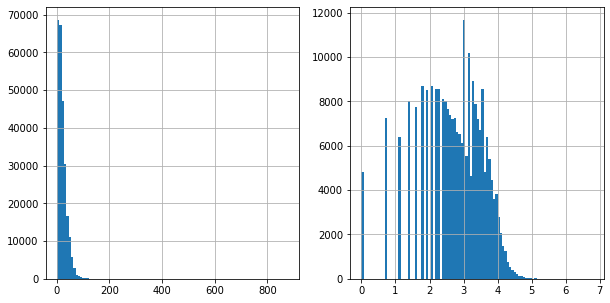

In [107]:
# target인 방문자 숫자를 histogram 그래프를 이용해서 그려보면 데이터가 치중되어있는 것을 볼 수 있다.
# np.log를 적용해서 치중된 것을 완화 시켜주자.
fg, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])
past[target_col].hist(bins=100, ax=ax[0])
past[target_col].apply(np.log).hist(bins=100, ax=ax[1])

### Xgboost를 학습 시키기 위해 pd.DataFrame 을 xgb.DMatrix 변환시킨다.

In [108]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)

eval_setting = [ (train_dmatrix, 'train'), (val_dmatrix, 'eval') ]

### Train XGB model

In [117]:
%%time
# 시도해볼 파라미터들
try_xgb_params = {'colsample_bytree': 0.4,
                  'eta': 0.1,
                  'gamma': 2,
                  'max_depth': 4,
                  'min_child_weight': 100,
                  'objective': 'reg:linear',
                  'seed': 2018,
                  'subsample': 1}

# xgboost 학습
model = xgb.train(params=try_xgb_params,
                  dtrain=train_dmatrix, 
                  num_boost_round=100000, 
                  evals=eval_setting,
                  early_stopping_rounds=50,
                  verbose_eval=100
                 )

# best_iteration과 best_score를 model에서 뽑는다.
best_iteration = model.best_iteration
best_score = model.best_score

print ('best_score: {}, best_iteration: {}'.format(best_score, best_iteration))

[15:24:54] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.20454	eval-rmse:2.21928
[100]	train-rmse:0.49128	eval-rmse:0.48897
[178]	train-rmse:0.48853	eval-rmse:0.48851
best_score: 0.488154, best_iteration: 128
CPU times: user 21.9 s, sys: 14.4 ms, total: 21.9 s
Wall time: 5.49 s


### Feature importance
중요한 feature 들을 feature_importance 테이블로 보여주고, 그래프를 통해 시각화해준다.

,importance
day_of_year,0.103004
mean_visitors,0.093944
median_visitors,0.087268
days_since_20160101,0.075346
n_reserve_visitors,0.072961
min_visitors,0.056748
max_visitors,0.051025
week_of_year,0.037196
air_genre_name_int,0.034335
n_reserves,0.033381


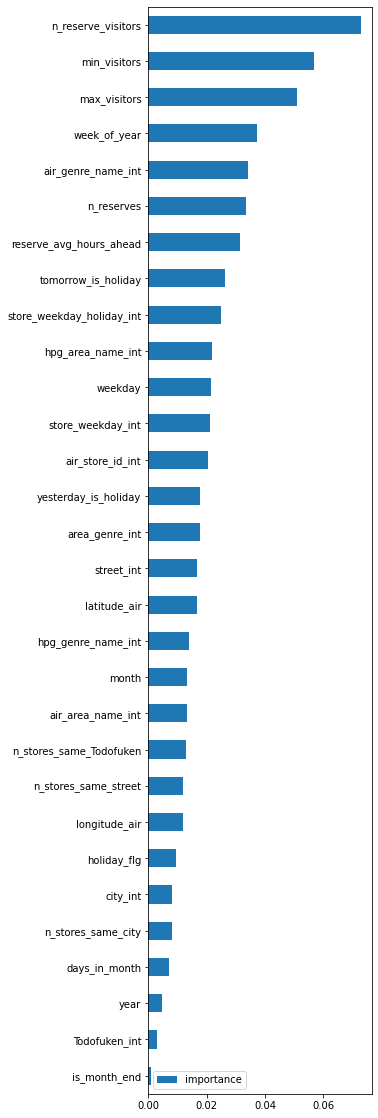

In [118]:
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance / feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot.barh(figsize=[4,20])
feature_importance.sort_values(by='importance', ascending=False).head(30)

가장 중요한 feature는 `n_reserve_visitors`.   
즉, 예약 방문 한 사람들의 숫자이며, 2번째와 3번째는 최소, 최대 방문자인 것을 확인할 수 있다.

### 제출할 submission 제작

In [119]:
# train_selector = past.visit_date.between('2016-04-01', '2017-03-09')
X_train = past[use_cols]
y_train = past[target_col].apply(np.log1p)    # apply np.log1p() (log(1+x)) to visitors count, to correct for high skewness

print('Training set dimensions...')
print('- X_train:', X_train.shape)
print('- y_train:', y_train.shape)

Training set dimensions...
- X_train: (252108, 34)
- y_train: (252108,)


In [120]:
%%time

# xgb model 학습
model = xgb.train(params=try_xgb_params, 
                  dtrain=xgb.DMatrix(X_train, label=y_train), 
                  num_boost_round=best_iteration*2
                 )

[15:25:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 39 s, sys: 154 ms, total: 39.1 s
Wall time: 10.4 s


In [121]:
# model을 사용해서 예측하기(predict)
future[target_col] = model.predict(xgb.DMatrix(future[use_cols]))
future[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
# 최종 submission
sub = future[[id_col, target_col]].copy()
sub.tail()

,id,visitors
284122,air_fff68b929994bfbd_2017-05-27,6.953861
284123,air_fff68b929994bfbd_2017-05-28,3.480453
284124,air_fff68b929994bfbd_2017-05-29,3.874567
284125,air_fff68b929994bfbd_2017-05-30,4.055150
284126,air_fff68b929994bfbd_2017-05-31,4.096997


In [123]:
sub.to_csv('./submission.csv', index=False)

# 캐글에 제출 했을 때 점수....

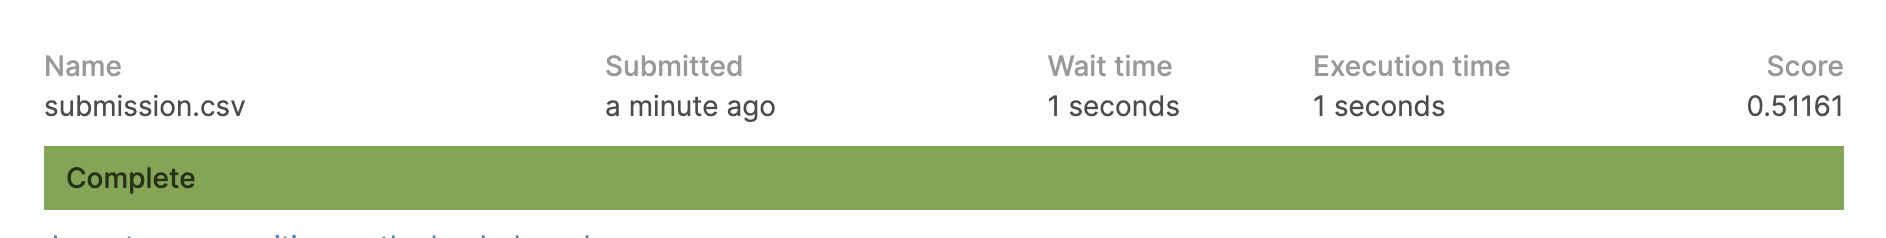

## XGBoost Manual Tuning
[공식문서](https://xgboost.readthedocs.io/en/latest/parameter.html)   
[한국어로 번역된 블로그](https://injo.tistory.com/44)   

성능을 개선하기 위한 다양한 하이퍼파라미터들을 시도해본다.

Parameters for Tree Booster
- eta: alias learning_rate. Step size. Smaller → learn slower, increase num_round to compensate.
- gamma: alias min_split_loss. cost of a further partition. Larger gamma → simpler trees
- colsample_bytree: subsample ratio of columns when constructing each tree. Range (0,1]. 칼럼 샘플 비율
- subsample: Subsample ratio of the training instances. randomly select subsample portion of observations in training
- min_child_weight : Minimum sum of instance weight (hessian) needed in a child

In [124]:
# 기본 xgb 파라미터들을 basic_xgb_params에 담는다.
basic_xgb_params = {
    'objective': 'reg:linear',
    'eta': 0.1,
    'seed': 2018
}

In [125]:
# 우리가 임의로 정해준 파라미터들을 search_xgb_params에 담는다.
search_xgb_params = {
    'max_depth': [4, 8, 12, 16, 20, 24, 28, 32],
    'gamma': [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3],
    'colsample_bytree': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    'subsample': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    'min_child_weight': [0, 1, 3, 10, 20, 30, 50, 100]
}

In [126]:
%%time

best_params = basic_xgb_params.copy()

# 임의로 설정해준 params들을 돌아가면서 model에 학습시켜서 best 파라미터를 뽑는다. 
for p in search_xgb_params:    # tune one parameter at each iteration, other parameters use default
    print('Tuning parameter {}, range: {}'.format(p, search_xgb_params[p]))
    test_params = best_params
    scores = []
    
    for v in search_xgb_params[p]:    # go thru each value of the parameter we're testing
        test_params[p] = v
        test_model = xgb.train(params=test_params, 
                               dtrain=train_dmatrix, 
                               num_boost_round=100000, 
                               evals=eval_setting,
                               early_stopping_rounds=50,
                               verbose_eval=False
                              )
        best_iter = test_model.best_iteration
        best_score = test_model.best_score
        scores.append([v, best_score])
        print('    {p}={v}: best_score={s}, best_iter={it}'.format(p=p, v=v, s=best_score, it=best_iter))
        
    scores.sort(key=lambda x: x[1])
    best_value = scores[0][0]
    best_score = scores[0][1]
    best_params[p] = best_value
    print("============================================================")
    print('  Best value for {p}: {v} (score {s})'.format(p=p, v=best_value, s=best_score))

print("============================================================")
print(best_params)

Tuning parameter max_depth, range: [4, 8, 12, 16, 20, 24, 28, 32]
[15:25:11] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
    max_depth=4: best_score=0.490788, best_iter=71
[15:25:18] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
    max_depth=8: best_score=0.516011, best_iter=63
[15:25:32] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
    max_depth=12: best_score=0.534083, best_iter=58
[15:25:56] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
    max_depth=16: best_score=0.556409, best_iter=50
[15:26:32] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
    max_depth=20: best_score=0.577962, best_iter=47
[15:27:28] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now dep

In [127]:
# model의 성능이 가장 좋을 때의 best 파라미터
best_params

{'objective': 'reg:linear',
 'eta': 0.1,
 'seed': 2018,
 'max_depth': 4,
 'gamma': 2,
 'colsample_bytree': 0.6,
 'subsample': 0.4,
 'min_child_weight': 20}

## best_params적용한 모델 학습

In [128]:
%%time
# 시도해볼 파라미터들
try_xgb_params = {'colsample_bytree': 0.6,
                  'eta': 0.1,
                  'gamma': 2,
                  'max_depth': 4,
                  'min_child_weight': 20,
                  'objective': 'reg:linear',
                  'seed': 2018,
                  'subsample': 0.4}

# xgboost 학습
model = xgb.train(params=try_xgb_params,
                  dtrain=train_dmatrix, 
                  num_boost_round=100000, 
                  evals=eval_setting,
                  early_stopping_rounds=50,
                  verbose_eval=100
                 )

best_iteration = model.best_iteration
best_score = model.best_score

print ('best_score: {}, best_iteration: {}'.format(best_score, best_iteration))

[15:39:58] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.20454	eval-rmse:2.21931
[100]	train-rmse:0.49066	eval-rmse:0.48799
[182]	train-rmse:0.48738	eval-rmse:0.48810
best_score: 0.4876, best_iteration: 132
CPU times: user 33.9 s, sys: 49.8 ms, total: 33.9 s
Wall time: 8.5 s


In [129]:
model = xgb.train(params=try_xgb_params, 
                  dtrain=xgb.DMatrix(X_train, label=y_train), 
                  num_boost_round=best_iteration*2
                 )

[15:41:54] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [130]:
future[target_col] = model.predict(xgb.DMatrix(future[use_cols]))
future[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
sub = future[[id_col, target_col]].copy()
sub.tail()

,id,visitors
284122,air_fff68b929994bfbd_2017-05-27,6.674602
284123,air_fff68b929994bfbd_2017-05-28,3.377763
284124,air_fff68b929994bfbd_2017-05-29,3.837590
284125,air_fff68b929994bfbd_2017-05-30,3.848933
284126,air_fff68b929994bfbd_2017-05-31,3.922173


In [132]:
sub.to_csv('./submission.csv', index=False)

# 미약한 도약을 한 캐글 점수를 보고 계십니다.

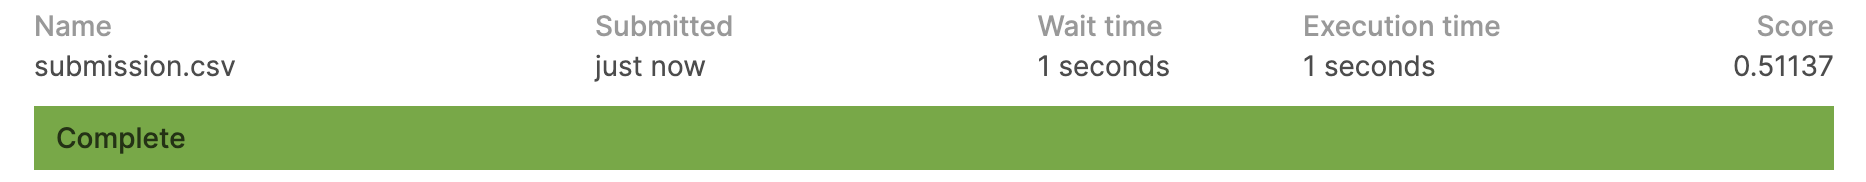